<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Seismic sources - CMT</div>
  </div>
</div>


This script will get an event from IRIS and retrieve a seismogram for a selected station. It will compare the raw trace against a simple, analytical solution.<br>

**Questions**:<br> 
**Which velocity roughly fits best the P-wave arrival?**<br>
**How about a station farther away?**<br>
**How about a different event?**<br> 


for more notebooks in seismology, see:<br>
http://krischer.github.io/seismo_live/

## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [142]:
from __future__ import print_function

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5

import os,sys

## numpy
import numpy as np

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology


In [143]:
import obspy




## 1. Event information

Let's look at the 2011 Virginia quake.<br>

wikipedia: [2011 Virginia earthquake](https://en.wikipedia.org/wiki/2011_Virginia_earthquake)<br>
video footage from inside the Washington Monument: [youtube Washington Monument](https://www.youtube.com/watch?v=PRiOlPPcIPo)<br>
global CMT: [virginia event](https://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2011&mo=8&day=23&oyr=1976&omo=1&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=1&lmw=5.5&umw=6&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=4)<br>


Specify the event time.<br>

Virginia quake: (Magnitude Mw ~ 5.8)<br>
August 23, 2011, UTC17:51:07.3 -> 2011-08-23T17:51:07.3
GlobalCMT: Event ID 201108231751A



In [144]:
print("getting event information...")
from obspy.clients.fdsn import Client

event_time = obspy.UTCDateTime("2011-08-23T17:51:07.30")

# data client
# data centers: FDSN, IRIS, ORFEUS, IPGP, ETH, GFZ, RESIF, GEONET, USGS, ..
c = Client("IRIS")  # no focal mechanism info for Virginia
#client = Client("USGS")   # no focal mechanism info for Virginia
#client = Client("ISC") # no focal mechanism info for Virginia

starttime = event_time - 10 * 60
endtime = event_time + 10 * 60
Mw_min = 5.0

catalog = c.get_events(starttime=starttime, endtime=endtime, minmagnitude=Mw_min)
# or
#catalog = c.get_events(eventid=3320897)
print("Event catalog:")
print(catalog)

print("Event origin:")
print(catalog[0].preferred_origin())  

print("Event focal mechanism:")
print(catalog[0].preferred_focal_mechanism())

getting event information...
Event catalog:
1 Event(s) in Catalog:
2011-08-23T17:51:03.600000Z | +37.919,  -78.040 | 5.7 MW
Event origin:
Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=5444272")
	          time: UTCDateTime(2011, 8, 23, 17, 51, 3, 600000)
	     longitude: -78.0396
	      latitude: 37.919
	         depth: 7700.0
	 creation_info: CreationInfo(author='ISC')
Event focal mechanism:
None


Unfortunately, that won't give us the moment tensor information yet.<br>
We will use the global CMT ID to retrieve it from the IRIS SPUD (the Searchable Product Depository) service:

Virigina quake: <br>
globalCMT ID: *201108231751A* (see [globalcmt page](https://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2011&mo=8&day=23&oyr=1976&omo=1&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=1&lmw=5.5&umw=6&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=4))<br>
IRIS SPUD moment tensor ID: *C201108231751A*  (see [IRIS SPUD page](http://ds.iris.edu/spud/momenttensor/999300)) <br>

In [145]:
# get moment tensor through IRIS SPUD (the Searchable Product Depository)
# Virigina quake: C201108231751A
gcmt_eventid = "C201108231751A"
url_ndk = "http://ds.iris.edu/spudservice/momenttensor/gcmtid/" + gcmt_eventid + "/ndk"
catalog = obspy.read_events(url_ndk)

print(catalog)


1 Event(s) in Catalog:
2011-08-23T17:51:05.700000Z | +37.910,  -77.930 | 5.73 Mwc


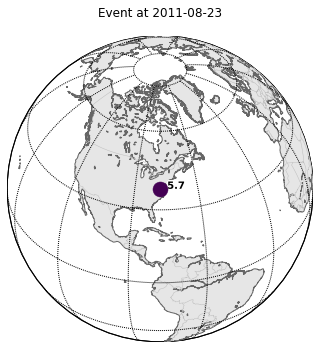

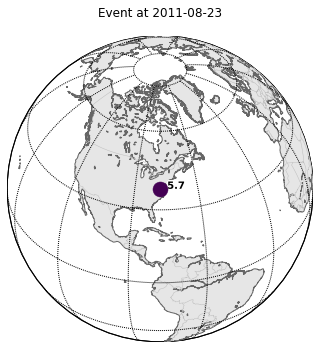

In [146]:
catalog.plot("ortho")

In [359]:
# select virginia event
event = catalog[0]
print("Event:")
print(event.short_str())

print("Event info:")
origin = event.preferred_origin()
#print(origin)

t0 = origin.time
lat = origin.latitude
lon = origin.longitude
dep = origin.depth

print("  time   : ",t0)
print("  lat/lon: ",lat,"/",lon,"(degree)")
print("  depth  : ",dep,"(m)")

# magnitude
magnitude = event.preferred_magnitude()
if magnitude == None:
    M = 0.0
    M_type = "no magnitude information available"
else:
    M = magnitude.mag
    M_type = magnitude.magnitude_type
print("  magnitude: ",M,"type ",M_type)

# moment tensor
print("Event mechanism:")
focal = event.preferred_focal_mechanism()     
if focal == None:    
    mt = []
    hdur = 0.0
    print("  number of mechanisms: ",len(event.focal_mechanisms),focal)
    print("  no focal mechanism information available")
else:
    #print(focal)
    # source time function - half-duration
    hdur = 0.5 * focal.moment_tensor.source_time_function['duration']
    print("  source time function: ", focal.moment_tensor.source_time_function)
    print("  source time function: half-duration hdur = ", hdur)
    # note: moment tensor solution from globalCMT is in [dyne cm] units
    mt_tensor = focal.moment_tensor.tensor
    m_rr = mt_tensor.m_rr
    m_tt = mt_tensor.m_tt
    m_pp = mt_tensor.m_pp
    m_rt = mt_tensor.m_rt
    m_rp = mt_tensor.m_rp
    m_tp = mt_tensor.m_tp
    mt = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]
    
print("  moment tensor: ",mt)


Event:
2011-08-23T17:51:05.700000Z | +37.910,  -77.930 | 5.73 Mwc
Event info:
  time   :  2011-08-23T17:51:05.700000Z
  lat/lon:  37.91 / -77.93 (degree)
  depth  :  12000.0 (m)
  magnitude:  5.73 type  Mwc
Event mechanism:
  source time function:  SourceTimeFunction(type='triangle', duration=3.6)
  source time function: half-duration hdur =  1.8
  moment tensor:  [4.71e+17, 3800000000000000.0, -4.74e+17, 3.99e+16, -8.05e+16, -1.23e+17]


Let's plot the focal mechanism as a beachball.

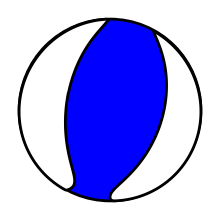

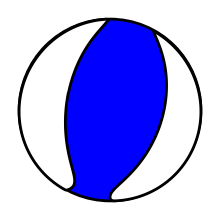

In [360]:
from obspy.imaging.beachball import beachball
beachball(mt, size=200, linewidth=2, facecolor='b')

## 2. Station information

Let's get some information about which stations would have waveform data

In [361]:
print("getting station information...")

# gets station informations
t1 = event_time
t2 = t1 + 10 * 60

# global network stations (naming starts with A***)
inventory_IU = c.get_stations(network="IU", station="A*",
                                starttime=t1,endtime=t2)
print(inventory_IU)

# US network stations (naming starts with A*** or R****)
inventory_US = c.get_stations(network="US", station="A*,R*",
                                starttime=t1,endtime=t2)
print(inventory_US)

# Lamont-Doherty stations (naming starts with S***)
inventory_LD = c.get_stations(network="LD", station="S*",
                                starttime=t1,endtime=t2)
print(inventory_LD)



getting station information...
Inventory created at 2020-02-11T22:49:04.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.40
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-08-23...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (4):
			IU.ADK (Global Seismograph Network - IRIS/USGS)
			IU.AFI (Global Seismograph Network - IRIS/USGS)
			IU.ANMO (Global Seismograph Network - IRIS/USGS)
			IU.ANTO (Global Seismograph Network - IRIS/USGS)
		Channels (0):

Inventory created at 2020-02-11T22:49:05.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.40
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-08-23...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			US
		Stations (6):
			US.AAM (United States National Seismic Network)
			US.ACSO (United States National Seismic Network)
			US.AGMN (United States National Seismic Network)
			US.AHID (United States Nat

We will use station SDMD (Soldier's Delight, Maryland) from the Lamont-Doherty network, which is as close to Washington as we can get.

In [362]:
print("inventory LD: ",len(inventory_LD))
# LD network
network = inventory_LD[0]
print(network)

# SDMD is second station
station = network[1]
print(station)


inventory LD:  1
Network LD (Lamont-Doherty Cooperative Seismographic Network (LCSN))
	Station Count: 2/78 (Selected/Total)
	1970-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (2):
			LD.SCOM (Lamont-Doherty Cooperative Seismographic Network)
			LD.SDMD (Lamont-Doherty Cooperative Seismographic Network)
		Channels (0):

Station SDMD (Lamont-Doherty Cooperative Seismographic Network)
	Station Code: SDMD
	Channel Count: 0/12 (Selected/Total)
	2001-11-01T00:00:00.000000Z - 
	Access: open 
	Latitude: 39.41, Longitude: -76.84, Elevation: 212.0 m
	Available Channels:



In [363]:
# seismograms
print("getting waveform...")

# Stations
# station: Soldier's Delight, Maryland - station name: SDMD, network name: LD, channel: HHZ
#          Guralp CMG-3T three-component, broadband seismometer, with a standard bandwidth of 0.01-50Hz 
net = "LD"
sta = "SDMD"
cha = "HHZ"

# time window
tshift_begin = - 1 * 60 # 1 min earlier
tshift_end = 5 * 60 # 5 min after
t1 = t0 + tshift_begin             
t2 = t0 + tshift_end

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location="*", channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)
print("")


getting waveform...
1 Trace(s) in Stream:
LD.SDMD..HHZ | 2011-08-23T17:50:05.700000Z - 2011-08-23T17:56:05.700000Z | 100.0 Hz, 36001 samples



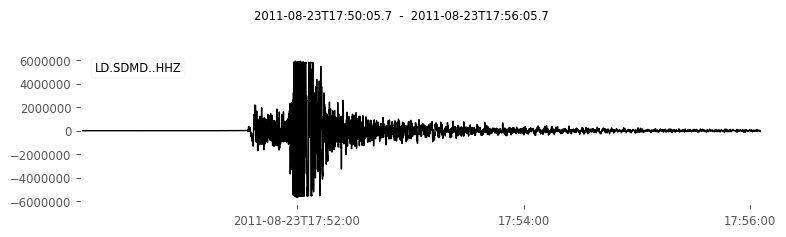

trace:
  duration =  360.01 s  =  6.000166666666667 min  =  0.10000277777777779 h
  Nyquist frequency =  50.0
  minimum frequency =  0.0027777006194272384



In [364]:
# plotting trace
st.plot()

# trace statistics
tr = st[0]
#print(tr.stats)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt

freq_Ny = 1.0/(2.0 * dt)  # Nyquist frequency
freq_min = 1./duration    # minimal possible frequency for length of trace

print("trace:")
print("  duration = ",duration,"s"," = ",duration/60.,"min"," = ",duration/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny)
print("  minimum frequency = ",freq_min)
print("")


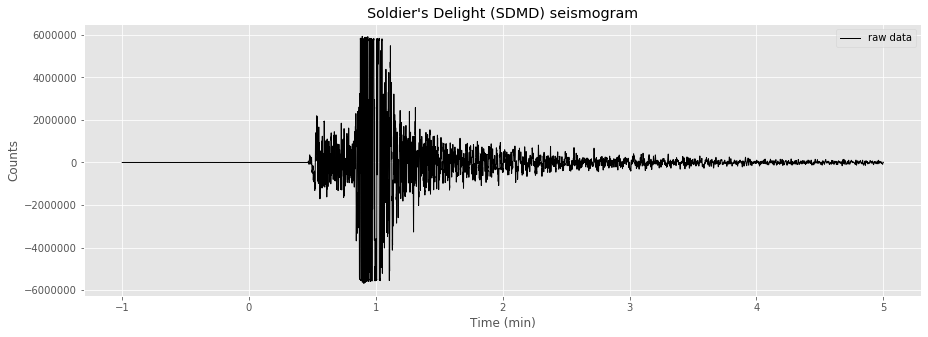

In [365]:
# time axis for plotting (in min)
t_d = np.linspace(0,duration,npts) / (60.0)  
# shift time scale to have 0 at event origin time
t_d += tshift_begin / 60.0

# plotting
plt.title("Soldier's Delight (SDMD) seismogram")
plt.plot(t_d, st[0].data, color='black', linewidth=1.0,label="raw data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Counts")
plt.show()


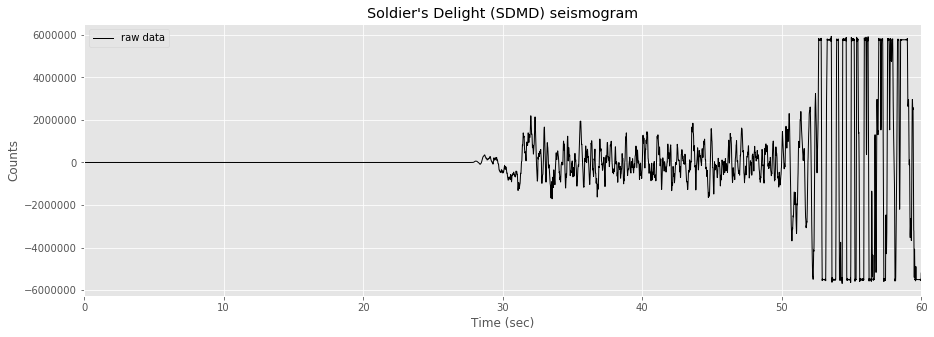

In [366]:
# zoom-in
t_ds = t_d * 60 # in sec

# plotting
plt.xlim(0.0, 60.0)
# or matplotlib version >= 3.1.3
#plt.get_xaxis().set_xlim(0.0, 60.0)
plt.title("Soldier's Delight (SDMD) seismogram")
plt.plot(t_ds, st[0].data, color='black', linewidth=1.0,label="raw data")
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Counts")
plt.show()


# 3. Ray paths

Plots simple ray paths for P- and S-waves.
Let's start with getting the epicentral distance from station to the event.

In [367]:
## epicentral distance
# station lat/lon
sta_lat = station.latitude
sta_lon = station.longitude
print("station lat/lon: ",sta_lat,"/",sta_lon)

# event lat/lon
lat = event.preferred_origin().latitude
lon = event.preferred_origin().longitude
print("event   lat/lon: ",lat,"/",lon)

# epicentral distance
from math import pi,sin,cos,asin,sqrt
# converts to radians
lat1_radians = lat * pi/180.0
lon1_radians = lon * pi/180.0
lat2_radians = sta_lat * pi/180.0
lon2_radians = sta_lon * pi/180.0
    
mid_lat = (lat1_radians - lat2_radians)/2.0
mid_lon = (lon1_radians - lon2_radians)/2.0
    
tmp = sqrt( pow(sin(mid_lat),2) + cos(lat1_radians)*cos(lat2_radians)*pow(sin(mid_lon),2) )
    
distance_radians = 2.0 * asin(tmp)
dist = distance_radians * 180.0/pi
print("epicentral distance :",dist,"(degree)")


station lat/lon:  39.410198 / -76.840302
event   lat/lon:  37.91 / -77.93
epicentral distance : 1.724676400371288 (degree)


Now let calculate and plot rays using the [TauP toolkit](https://www.seis.sc.edu/taup/) calculator implemented in obspy.

In [368]:
# rays using TauP
from obspy.taup import TauPyModel
# models: prem, iasp91, ak135f
model = TauPyModel(model="prem")

# event depth
dep_km = event.preferred_origin().depth / 1000.0 # in km

print("tauP:")
print("  distance: ",dist)
print("  depth   : ",dep_km,"(km)")

# get P & S arrival times
arrivals = model.get_travel_times(source_depth_in_km=dep_km,distance_in_degree=dist,phase_list=["P", "S"])

print(arrivals)  


tauP:
  distance:  1.724676400371288
  depth   :  12.0 (km)
8 arrivals
	P phase arrival at 27.239 seconds
	P phase arrival at 29.760 seconds
	P phase arrival at 29.902 seconds
	P phase arrival at 33.165 seconds
	S phase arrival at 48.891 seconds
	S phase arrival at 52.278 seconds
	S phase arrival at 52.520 seconds
	S phase arrival at 60.112 seconds


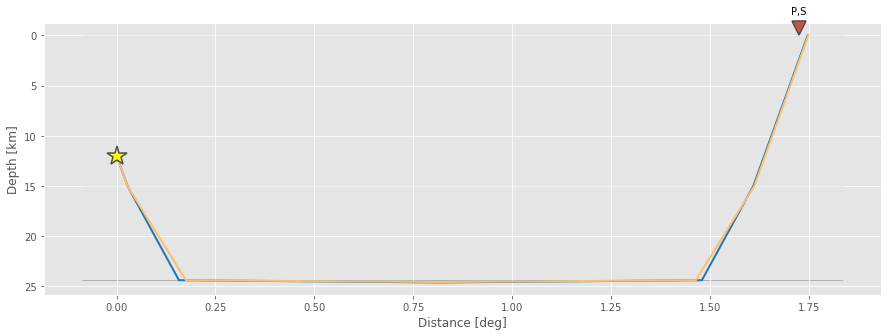

In [369]:
# since we have multiple arrivals, let's focus on the first ones
# only P-wave arrivals
arrivals_P = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["P"])
#print(arrivals_P)

# only S-wave arrivals
arrivals_S = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["S"])
#print(arrivals_S)

# plots only first P & S rays
arrivals = obspy.taup.tau.Arrivals([],model=model.model)
arrivals.append(arrivals_P[0])
arrivals.append(arrivals_S[0])
ax = arrivals.plot_rays(plot_type="cartesian",label_arrivals=True)


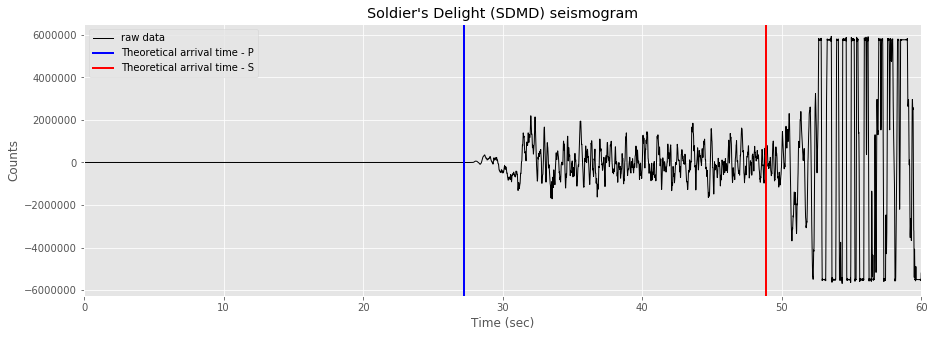

In [370]:
# use arrival times as labels in the seismogram
# travel times
t1 = arrivals_P[0].time  # in sec
t2 = arrivals_S[0].time

# plotting
plt.xlim(0.0, 60.0)
plt.title("Soldier's Delight (SDMD) seismogram")
plt.plot(t_ds, st[0].data, color='black', linewidth=1.0,label="raw data")
#plt.vlines(t1,-7.e6, 0, color='blue', linewidth=2.0, label="Theoretical arrival time - P") 
#plt.vlines(t2,-7.e6, 0, color='red', linewidth=2.0, label="Theoretical arrival time - S") 
plt.axvline(t1, color='blue', linewidth=2.0, label="Theoretical arrival time - P") 
plt.axvline(t2, color='red', linewidth=2.0, label="Theoretical arrival time - S") 
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Counts")
plt.show()


# 4. Analytical solution - Green's function

For a homogeneous medium with velocity $v$, the analytical Green's function at receiver position $x_r$ and time $t$ can be written as
$$G(x_r, t; x_s, 0) = \frac{1}{4 \pi r}\frac{1}{v^2} \delta( t - \frac{r}{v})$$
with distance $r = x_r - x_s$. 
Note that the factor $\frac{1}{v^2}$ acts as an additional amplitude term with respect to the geometrical speading $\frac{1}{4 \pi r}$. 
For slower S-wave velocities $v_s$, the amplitude thus becomes bigger compared to faster P-wave velocities $v_p$ (typically, $v_p$ > $v_s$ for rocks).

receiver distance       :  191.775265824887 (km)
homogeneous velocity    :  7.0 (km/s)
theoretical arrival time:  27.396466546412427 (s)
Gaussian half-duration:  1.8
min:  0.0 max:  2878312.288168912 len:  36001 len sft: 36001


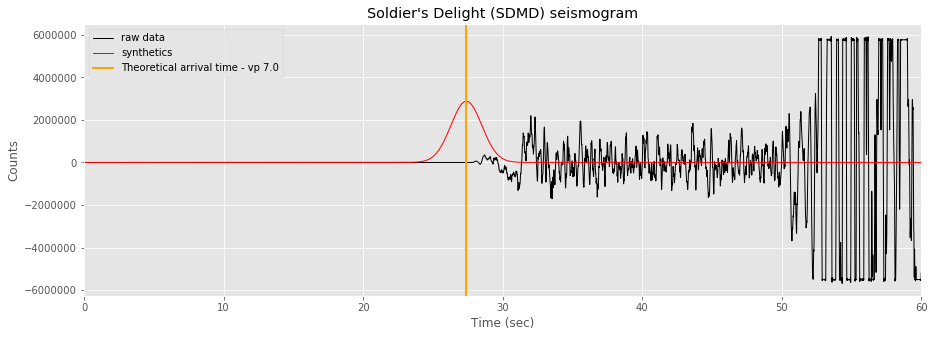

In [371]:
## setup 
# Vp velocity
vp = 7.0         # km/s
r_earth = 6371.0 # earth radius in km

# receiver distance in km
dist_km = distance_radians * r_earth
# theoretical arrival time
t_arr = dist_km / vp

print("receiver distance       : ",dist_km,"(km)")
print("homogeneous velocity    : ",vp,"(km/s)")
print("theoretical arrival time: ",t_arr,"(s)")

# time axis     
x = t_ds.copy()

# analytical Green's function
def Green_func(r,t,vel,dt=1.e-9):
    # distance r (in km), time t (in s), velocity vp (in km/s)
    from math import pi

    # zero distance case
    if abs(r) <= 1.e-9: 
        if t == 0.0:
            return 1.0
        else:
            return 0.0 
    
    # amplitude factor        
    fac = 1./(4 * pi * r) * 1.0 / vel**2

    # retarded time
    ret = t - r / vel

    # numerically t - r/vel will hardly ever be exactly zero
    if abs(ret) <= dt:
        return fac
    else:
        return 0.0

# Green's function array
G = np.zeros(len(x))
for i,t in enumerate(x):
    G[i] = Green_func(dist_km,t,vp,dt=(x[1]-x[0]))
    #if G[i] > 0: print("G = ",G[i],i,t)

# source time function    
# assumes Gaussian source time function with a half-duration of the source
def Gaussian_triangle_func(x, mu, sigma):
    # Gaussian function: https://en.wikipedia.org/wiki/Gaussian_function
    #f = 1.0/(sigma * np.sqrt(2.0*np.pi)) * np.exp(-np.power((x - mu)/sigma, 2.0) / 2.0)
    # slightly modified to better match a triangle shape
    sigma_tri = sigma / 1.628
    f = 1.0/(sigma_tri * np.sqrt(2.0*np.pi)) * np.exp(-np.power((x - mu)/sigma_tri, 2.0) / 2.0)
    return f

print("Gaussian half-duration: ",hdur)
stf = Gaussian_triangle_func(x,0.0,hdur)

# scales by moment tensor component m_rr
stf = stf * mt[0]

# note: comparing displacement solution with a count scale would makes no sense, so ignore amplitudes.
#       one would need to remove the instrument response from raw data to obtain displacement values.
#       here, we just scales the source time function to fall within the range of the raw data counts
stf = stf * 1.e-6

# convolves Green's function with source time function
syn = np.convolve(stf, G)

# note: Green's function and source time function arrays are shifted to range [-60,+300]
#       the convolution result needs to be shifted to account for the STF not starting at 0
ishift = np.argmax(x >= 0.0)  # index of first positive value (where value 0 lies)
syn = syn[ishift:len(x)+ishift]
print("min: ",syn.min(),"max: ",syn.max(),"len: ",len(syn),"len sft:",len(stf))

# plotting
plt.xlim(0.0, 60.0)
#plt.title("synthetic seismogram")
#plt.plot(x, G, color='blue', linewidth=1.0,label="Green's function")
#plt.plot(x, stf, color='black', linewidth=1.0,label="STF")
#plt.plot(x, syn, color='red', linewidth=1.0,label="synthetics")

plt.title("Soldier's Delight (SDMD) seismogram")
plt.plot(t_ds, st[0].data, color='black', linewidth=1.0,label="raw data")
plt.plot(x, syn, color='red', linewidth=1.0,label="synthetics")
plt.axvline(t_arr, color='orange', linewidth=2.0, label="Theoretical arrival time - vp {}".format(vp)) 
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Counts")
plt.show()


Now play with the example, try out different velocities, stations, events...